In [1]:
# Import libraries
import numpy as np
import pandas as pd
from scipy.spatial.distance import cosine
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pickle

!pwd

/nfs/u50/zhanh279/SemEval-2026/subTask1


In [3]:
# ============================================================================
# PART 1: DATA LOADING & PREPARATION
# ============================================================================
test_embeddings=pd.read_pickle('data/task1_embedding_test.pickle')

test_sims=pd.read_pickle('data/test+sim.pickle')

test_LIWC=pd.read_pickle("data/task1_LIWC_test.pickle")

In [4]:
# Data preparation: combine all features (LIWC + Embedding + Sims + User embedding)
print("=" * 70)
print("STEP 1: DATA PREPARATION - LIWC + EMBEDDING + SIMS + USER_ID")
print("=" * 70)

# Load target data
test_targets = pd.read_pickle("data/test.pickle")

#load scalers (saved in subTask1/ directory by full_baseline.ipynb)
scaler_liwc = pickle.load(open("scaler_liwc.pkl", "rb"))
scaler_sim = pickle.load(open("scaler_sim.pkl", "rb"))

# Reset indices for alignment
test_sims = test_sims.reset_index(drop=True)
test_LIWC = test_LIWC.reset_index(drop=True)
test_embeddings = test_embeddings.reset_index(drop=True)
test_targets = test_targets.reset_index(drop=True)

# Extract user IDs
test_user_ids = test_targets['user_id'].values

# Extract LIWC features (numeric columns only, skip metadata and targets)
# Exclude: user_id, text_id, valence, arousal, collection_phase, is_words, num_tokens, is_seen_user
exclude_cols = ['user_id', 'text_id', 'valence', 'arousal', 'collection_phase', 'is_words', 'num_tokens', 'is_seen_user']
liwc_feature_cols = [col for col in test_LIWC.columns if col not in exclude_cols and col not in ['text', 'timestamp', 'text_tokens', 'text_liwc_tokens']]
test_liwc_features = test_LIWC[liwc_feature_cols].values.astype(float)

# Standardize LIWC features (using transform only, not fit_transform)
test_liwc_features = scaler_liwc.transform(test_liwc_features)

# Embedding features - extract from 'embedding' column
test_emb_features = np.array([np.array(x) for x in test_embeddings['embedding'].values])

# Extract sim features (columns with 'sim' in name)
sim_cols = [col for col in test_sims.columns if 'sim' in col.lower()]
test_sim_features = test_sims[sim_cols].values.astype(float)

# Standardize sim features (using transform only, not fit_transform)
test_sim_features = scaler_sim.transform(test_sim_features)

print(f"\nFeature dimensions:")
print(f"  LIWC: {test_liwc_features.shape[1]}")
print(f"  Embedding: {test_emb_features.shape[1]}")
print(f"  Sims: {test_sim_features.shape[1]}")
print(f"  User embedding: 32 (to be generated)")
print(f"  Total input: {test_liwc_features.shape[1] + test_emb_features.shape[1] + test_sim_features.shape[1] + 32}")

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")

# Combine all features
X_test_full = np.hstack([test_liwc_features, test_emb_features, test_sim_features])

# ========== FIXED: Load training user_id_map directly (DO NOT rebuild) ==========
# Load the user_id_map from training (saved in Baselines/ directory by full_baseline.ipynb)
train_user_id_map = pickle.load(open("Baselines/user_id_map.pkl", "rb"))
print(f"\nLoaded training user_id_map with {len(train_user_id_map)} users")

# Note: We will use manual embedding extraction, so we don't need test_user_ids_tensor
# But we still track how many users are seen vs unseen
test_is_seen_user = test_targets['is_seen_user'].values
num_seen = test_is_seen_user.sum()
num_unseen = len(test_is_seen_user) - num_seen
print(f"\nTest set user distribution:")
print(f"  Seen users (in training): {num_seen}")
print(f"  Unseen users (new): {num_unseen}")
print(f"  Total test samples: {len(test_user_ids)}")
# ================================================================================

# Convert to tensors (using all features, no selection)
X_test_tensor = torch.tensor(X_test_full, dtype=torch.float32).to(device)

print(f"\nTensor shapes:")
print(f"  X_test: {X_test_tensor.shape}")


STEP 1: DATA PREPARATION - LIWC + EMBEDDING + SIMS + USER_ID

Feature dimensions:
  LIWC: 79
  Embedding: 384
  Sims: 10
  User embedding: 32 (to be generated)
  Total input: 505

Using device: cuda

Loaded training user_id_map with 137 users

Test set user distribution:
  Seen users (in training): 692
  Unseen users (new): 1045
  Total test samples: 1737

Tensor shapes:
  X_test: torch.Size([1737, 473])


In [4]:
# ============================================================================
# PART 2: MODEL DEFINITION & LOADING
# ============================================================================

# Define MLPModel class (must match the training model)
class MLPModel(nn.Module):
    def __init__(self, feature_dim=505, num_users=1000, user_embedding_dim=32, hidden_dim=512):
        super(MLPModel, self).__init__()
        
        # User embedding
        self.user_embedding = nn.Embedding(num_users, user_embedding_dim)
        
        # Input dimension = features + user embedding
        input_dim = feature_dim + user_embedding_dim
        
        # MLP layers: [input → 512 → 256 → 128 → 2]
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, hidden_dim // 4)
        self.fc4 = nn.Linear(hidden_dim // 4, 2)  # Predict valence and arousal
        
    def forward(self, x_features, user_ids):
        # Get user embeddings
        user_embed = self.user_embedding(user_ids)
        
        # Concatenate features and user embedding
        combined = torch.cat([x_features, user_embed], dim=1)
        
        # MLP layers
        x = self.fc1(combined)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        
        return x

# Load the best model
print("\n" + "=" * 70)
print("STEP 2: LOAD PRE-TRAINED MODEL")
print("=" * 70)

# Initialize with the exact number of users from training
num_training_users = len(train_user_id_map)
model = MLPModel(feature_dim=X_test_tensor.shape[1], num_users=num_training_users, 
                 user_embedding_dim=32, hidden_dim=512)
model = model.to(device)
model.load_state_dict(torch.load("Baselines/best_model.pt", map_location=device))
model.eval()

print("✓ Model loaded successfully")
print(f"Model trained with {num_training_users} users")
print(f"Model architecture: {X_test_tensor.shape[1]} features + 32 user embedding → 512 → 256 → 128 → 2")



STEP 2: LOAD PRE-TRAINED MODEL
✓ Model loaded successfully
Model trained with 137 users
Model architecture: 473 features + 32 user embedding → 512 → 256 → 128 → 2


/tmp/ipykernel_1326015/1733637210.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("Baselines/best_model.pt", map_location=device))


In [5]:
# ============================================================================
# STEP 3: EXTRACT TRAINED USER EMBEDDINGS
# ============================================================================
print("\n" + "=" * 70)
print("STEP 3: EXTRACT TRAINED USER EMBEDDINGS")
print("=" * 70)

# Get the trained user embedding layer
trained_user_embeddings = model.user_embedding.weight.data.cpu().numpy()
print(f"Trained user embeddings shape: {trained_user_embeddings.shape}")
print(f"User embedding dimension: {trained_user_embeddings.shape[1]}")

# Save the embeddings for potential future use
np.save("Baselines/trained_user_embeddings.npy", trained_user_embeddings)
print(f"✓ Saved trained user embeddings")

# ============================================================================
# STEP 4: BUILD USER EMBEDDING MATRIX FOR TEST DATA
# ============================================================================
print("\n" + "=" * 70)
print("STEP 4: BUILD USER EMBEDDING MATRIX FOR TEST DATA")
print("=" * 70)

# Get is_seen_user information from test data
test_is_seen_user = test_targets['is_seen_user'].values

# Create user embedding matrix for test samples
user_embedding_dim = 32
test_user_embeddings = np.zeros((len(test_user_ids), user_embedding_dim), dtype=np.float32)

seen_count = 0
unseen_count = 0

for i, (uid, is_seen) in enumerate(zip(test_user_ids, test_is_seen_user)):
    if is_seen and uid in train_user_id_map:
        # User was in training data - use trained embedding
        embedding_idx = train_user_id_map[uid]
        test_user_embeddings[i] = trained_user_embeddings[embedding_idx]
        seen_count += 1
    else:
        # New user not in training - use zero vector
        test_user_embeddings[i] = np.zeros(user_embedding_dim, dtype=np.float32)
        unseen_count += 1

print(f"\nUser embedding results:")
print(f"  Users with trained embeddings (is_seen=True): {seen_count}")
print(f"  Users with zero embeddings (is_seen=False or not in map): {unseen_count}")
print(f"  Total: {len(test_user_ids)}")

# Convert to tensor
test_user_embeddings_tensor = torch.tensor(test_user_embeddings, dtype=torch.float32).to(device)
print(f"\n✓ User embeddings tensor shape: {test_user_embeddings_tensor.shape}")



STEP 3: EXTRACT TRAINED USER EMBEDDINGS
Trained user embeddings shape: (137, 32)
User embedding dimension: 32
✓ Saved trained user embeddings

STEP 4: BUILD USER EMBEDDING MATRIX FOR TEST DATA

User embedding results:
  Users with trained embeddings (is_seen=True): 692
  Users with zero embeddings (is_seen=False or not in map): 1045
  Total: 1737

✓ User embeddings tensor shape: torch.Size([1737, 32])


In [6]:
# Make predictions on test data with pre-extracted user embeddings
print("\n" + "=" * 70)
print("STEP 5: MAKE PREDICTIONS & SAVE RESULTS")
print("=" * 70)

model.eval()
with torch.no_grad():
    # Manually forward pass: combine features with pre-extracted user embeddings
    combined = torch.cat([X_test_tensor, test_user_embeddings_tensor], dim=1)
    
    # Pass through MLP layers
    x = model.fc1(combined)
    x = model.relu(x)
    x = model.dropout(x)
    x = model.fc2(x)
    x = model.relu(x)
    x = model.dropout(x)
    x = model.fc3(x)
    x = model.relu(x)
    x = model.dropout(x)
    test_predictions = model.fc4(x)

# Convert predictions to numpy
test_preds_np = test_predictions.cpu().numpy()

print(f"\nPredictions shape: {test_preds_np.shape}")
print(f"Sample predictions (first 5):")
print(f"  Valence: {test_preds_np[:5, 0]}")
print(f"  Arousal: {test_preds_np[:5, 1]}")

# Create results DataFrame
results_df = pd.DataFrame({
    'user_id': test_user_ids,
    'text_id': test_targets['text_id'].values,
    'pred_valence': test_preds_np[:, 0],
    'pred_arousal': test_preds_np[:, 1]
})

print(f"\nResults DataFrame shape: {results_df.shape}")
print(f"Results head:\n{results_df.head()}")

# Save to CSV
output_file = "pred_subtask1.csv"
results_df.to_csv(output_file, index=False)
print(f"\n✓ Predictions saved to {output_file}")



STEP 5: MAKE PREDICTIONS & SAVE RESULTS

Predictions shape: (1737, 2)
Sample predictions (first 5):
  Valence: [ 0.6591409   0.7786965   0.7647522   1.0521739  -0.20880483]
  Arousal: [0.7913671 1.0706167 1.1516346 1.0565709 0.5591217]

Results DataFrame shape: (1737, 4)
Results head:
   user_id  text_id  pred_valence  pred_arousal
0        3      256      0.659141      0.791367
1        3      257      0.778696      1.070617
2        3      258      0.764752      1.151635
3        3      249      1.052174      1.056571
4        3      250     -0.208805      0.559122

✓ Predictions saved to pred_subtask1.csv



STEP 6: VISUALIZE PREDICTIONS DISTRIBUTION


/tmp/ipykernel_1326015/178897353.py:31: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1, 1].boxplot(box_data, labels=['Valence', 'Arousal'], patch_artist=True)


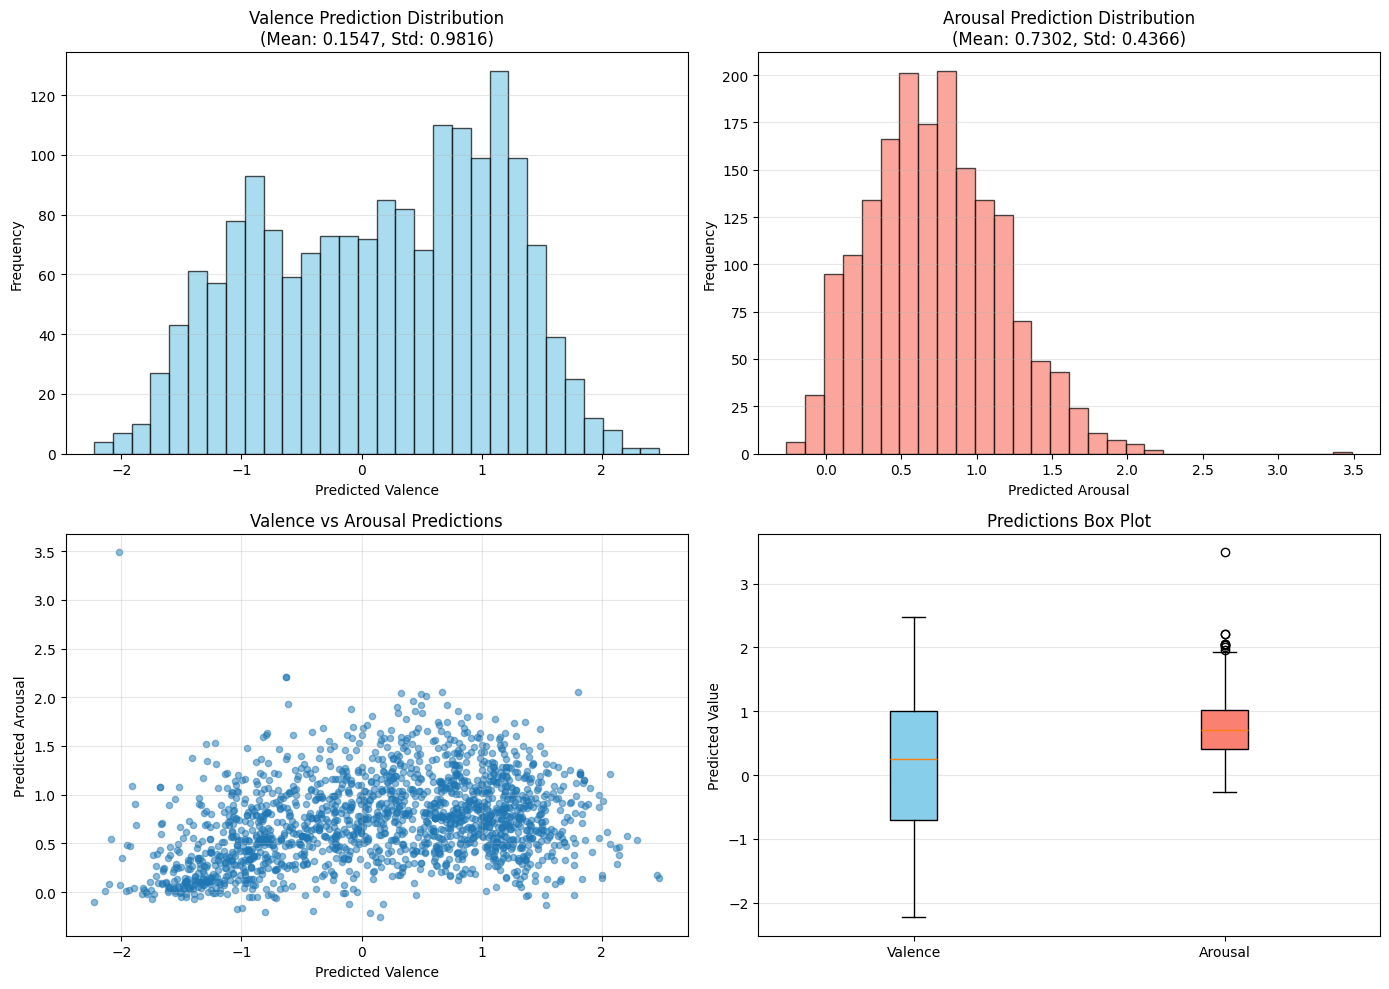


✓ Visualization saved as 'prediction_distribution.png'

Prediction Statistics:
Valence - Min: -2.2292, Max: 2.4800, Mean: 0.1547, Std: 0.9816
Arousal - Min: -0.2613, Max: 3.4877, Mean: 0.7302, Std: 0.4366


In [7]:
# Visualization of predictions distribution
print("\n" + "=" * 70)
print("STEP 6: VISUALIZE PREDICTIONS DISTRIBUTION")
print("=" * 70)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Panel 1: Valence prediction distribution
axes[0, 0].hist(test_preds_np[:, 0], bins=30, alpha=0.7, edgecolor='black', color='skyblue')
axes[0, 0].set_xlabel('Predicted Valence')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title(f'Valence Prediction Distribution\n(Mean: {test_preds_np[:, 0].mean():.4f}, Std: {test_preds_np[:, 0].std():.4f})')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Panel 2: Arousal prediction distribution
axes[0, 1].hist(test_preds_np[:, 1], bins=30, alpha=0.7, edgecolor='black', color='salmon')
axes[0, 1].set_xlabel('Predicted Arousal')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title(f'Arousal Prediction Distribution\n(Mean: {test_preds_np[:, 1].mean():.4f}, Std: {test_preds_np[:, 1].std():.4f})')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Panel 3: Scatter plot - Valence vs Arousal
axes[1, 0].scatter(test_preds_np[:, 0], test_preds_np[:, 1], alpha=0.5, s=20)
axes[1, 0].set_xlabel('Predicted Valence')
axes[1, 0].set_ylabel('Predicted Arousal')
axes[1, 0].set_title('Valence vs Arousal Predictions')
axes[1, 0].grid(True, alpha=0.3)

# Panel 4: Box plots
box_data = [test_preds_np[:, 0], test_preds_np[:, 1]]
bp = axes[1, 1].boxplot(box_data, labels=['Valence', 'Arousal'], patch_artist=True)
for patch, color in zip(bp['boxes'], ['skyblue', 'salmon']):
    patch.set_facecolor(color)
axes[1, 1].set_ylabel('Predicted Value')
axes[1, 1].set_title('Predictions Box Plot')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('prediction_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved as 'prediction_distribution.png'")

# Print summary statistics
print(f"\nPrediction Statistics:")
print(f"Valence - Min: {test_preds_np[:, 0].min():.4f}, Max: {test_preds_np[:, 0].max():.4f}, Mean: {test_preds_np[:, 0].mean():.4f}, Std: {test_preds_np[:, 0].std():.4f}")
print(f"Arousal - Min: {test_preds_np[:, 1].min():.4f}, Max: {test_preds_np[:, 1].max():.4f}, Mean: {test_preds_np[:, 1].mean():.4f}, Std: {test_preds_np[:, 1].std():.4f}")
